# Mumbai Walkability Analysis

This notebook uses pandana to download street network and points-of-interest data from OpenStreetMap and then calculate network accessibility to the points of interest for the city of Mumbai.

#### importing the relevant libraries

In [1]:
import pandana, time, os, pandas as pd, numpy as np

from pandana.loaders import osm

%matplotlib inline

## 1. Set up configuration of script

In [2]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
amenities = ['restaurant', 'bar', 'school']
distance = 1000
num_pois = 10
num_categories = len(amenities) + 1 #one for each amenity, plus one extra for all of them combined

# bounding box as a list of llcrnrlat, llcrnrlng, urcrnrlat, urcrnrlng
bbox = [18.87,72.77,19.27,72.97] #lat-long bounding box for Mumbai

In [3]:
# configure filenames to save/load POI and network datasets
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data/network_{}.h5'.format(bbox_string)
poi_filename = 'data/pois_{}_{}.csv'.format('_'.join(amenities), bbox_string)

In [4]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

## 2. Download points of interest (POIs) and network data from OSM

First get the points of interest - either load an existing set for the specified amenities and bounding box from CSV, or get it from the OSM API.

In [6]:
start_time = time.time()

if os.path.isfile(poi_filename):
    # if a points-of-interest file already exists, just load the dataset from that
    pois = pd.read_csv(poi_filename)
    method = 'loaded from CSV'
else:   
    # otherwise, query the OSM API for the specified amenities within the bounding box 
    osm_tags = '"amenity"~"{}"'.format('|'.join(amenities))
    pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3])
    
    # using the '"amenity"~"school"' returns preschools etc, so drop any that aren't just 'school' then save to CSV
    if not os.path.exists('./data'):
        os.mkdir('./data')
    pois = pois[pois['amenity'].isin(amenities)]
    pois.to_csv(poi_filename, index=False, encoding='utf-8')
    method = 'downloaded from OSM'
    
print('{:,} POIs {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['amenity', 'name', 'lat', 'lon']].head()

619 POIs downloaded from OSM in 213.43 seconds


,amenity,name,lat,lon
id,,,,
245653876,restaurant,Copper Chimney,18.927571,72.832575
246446609,school,Home for mental deficient childern,19.043673,72.925687
347125102,school,Apostolic Carmel Convent (Girl's School),19.055004,72.826210
347125358,school,Mount Mary's Convent High School,19.046234,72.822580
347145411,restaurant,Good Luck Restaurant,19.051757,72.824081


In [7]:
pois['amenity'].value_counts()

restaurant    449
school        130
bar            40
Name: amenity, dtype: int64

In [8]:
'"amenity"~"{}"'.format('|'.join(amenities))

'"amenity"~"restaurant|bar|school"'

In [9]:
# how many points of interest of each type of amenity did we retrieve?
pois['amenity'].value_counts()

restaurant    449
school        130
bar            40
Name: amenity, dtype: int64

Next get the street network data - either load an existing dataset for the specified bounding box from HDF5, or get it fresh from the OSM API.

In [10]:
net_filename

'data/network_18.87_72.77_19.27_72.97.h5'

In [11]:
start_time = time.time()
if os.path.isfile(net_filename):
    # if a street network file already exists, just load the dataset from that
    network = pandana.network.Network.from_hdf5(net_filename)
    method = 'loaded from HDF5'
else:
    # otherwise, query the OSM API for the street network within the specified bounding box
    network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
    method = 'downloaded from OSM'
    
    # identify nodes that are connected to fewer than some threshold of other nodes within a given distance
    lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
    network.save_hdf5(net_filename, rm_nodes=lcn) #remove low-connectivity nodes and save to h5
    
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](18.87000000,72.77000000,19.27000000,72.97000000);>;);out;'}"
Downloaded 14,392.6KB from www.overpass-api.de in 10.11 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 11.30 seconds
Returning OSM data with 110,493 nodes and 21,109 ways...
Edge node pairs completed. Took 59.11 seconds
Returning processed graph with 30,133 nodes and 42,911 edges...
Completed OSM data download and Pandana node and edge table creation in 74.56 seconds
Network with 30,133 nodes downloaded from OSM in 79.59 secs


When saving a Network to HDF5 it’s possible to exclude certain nodes. This can be useful when refining a network so that it includes only validated nodes. As an example, you can use the low_connectivity_nodes() method to identify nodes that may not be connected to the larger network, then exclude those nodes when saving to HDF5. In the current design of Pandana it’s not possible to modify a Network in place. Instead, save the network (with low-connectivity nodes removed) to HDF5 and then load it from that file by re-starting the notebook.

## 3. Calculate accessibility to any amenity we retrieved

In [12]:
# precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [13]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [14]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
network.set_pois(category='all', x_col=pois['lon'], y_col=pois['lat'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [15]:
# searches for the n nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head()

30,133 nodes


,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
206291066,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
245653028,656.538025,1000.000000,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
245653033,757.161987,924.476990,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
245653078,576.789001,786.257996,896.263000,896.263000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
245653086,284.286011,588.515015,735.853027,735.853027,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0


## 4. Plot accessibility from each node to any amenity

/home/asus/anaconda3/lib/python3.7/site-packages/pandana/network.py:458: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  bbox[1], bbox[0], bbox[3], bbox[2], ax=ax, **bmap_kwargs)


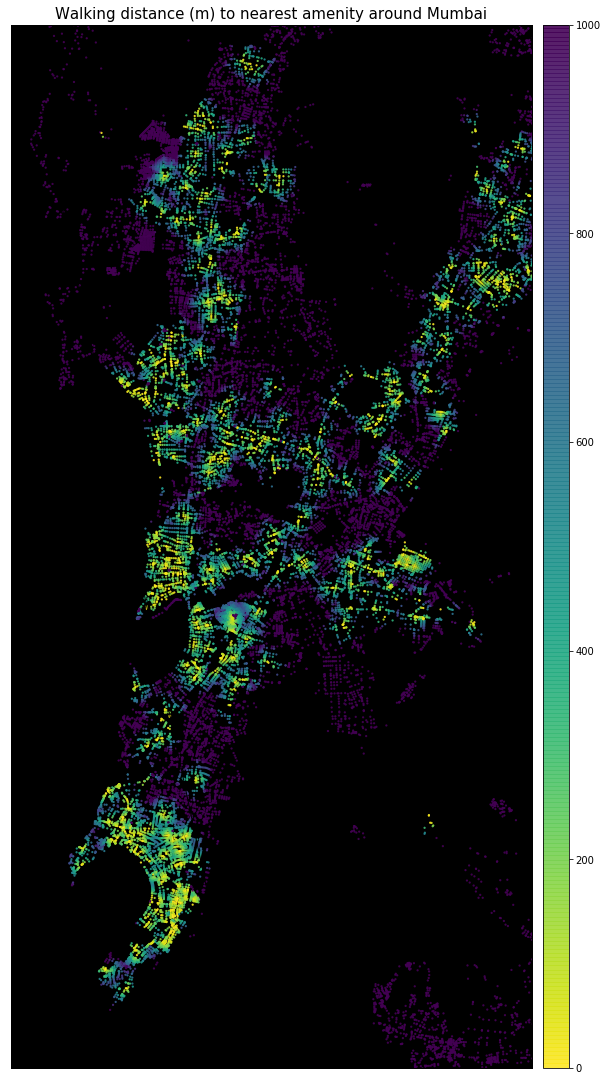

In [16]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Mumbai', fontsize=15)

if not os.path.exists('./images'):
    os.mkdir('./images')
fig.savefig('images/accessibility-all-Mumbai.png', dpi=200, bbox_inches='tight')

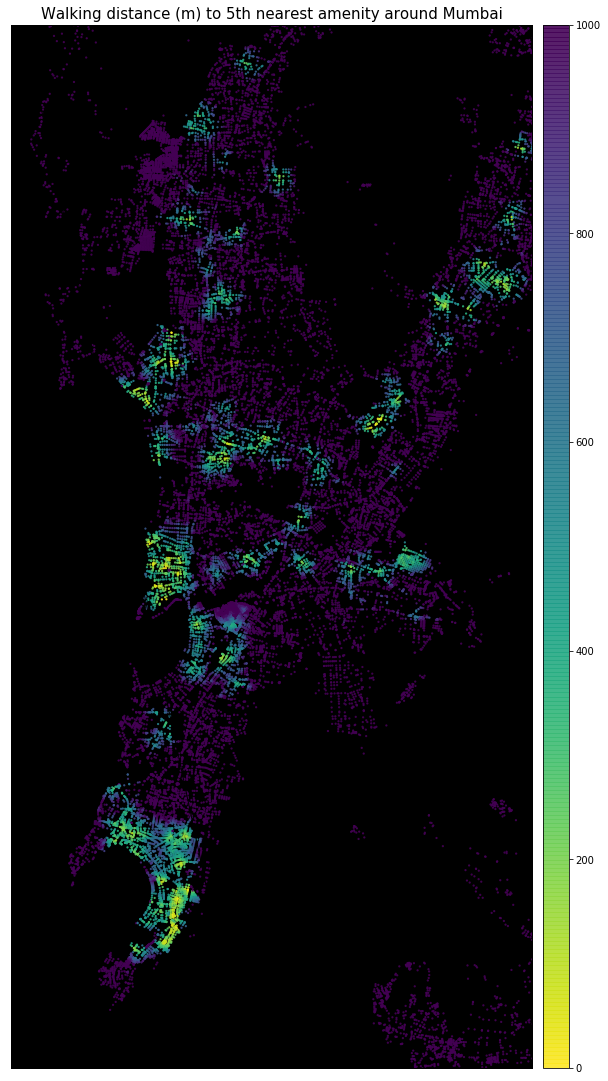

In [17]:
# distance to the 5th nearest amenity of any type
n = 3
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to 5th nearest amenity around Mumbai', fontsize=15)
fig.savefig('images/accessibility-all-5th-Mumbai.png', dpi=200, bbox_inches='tight')

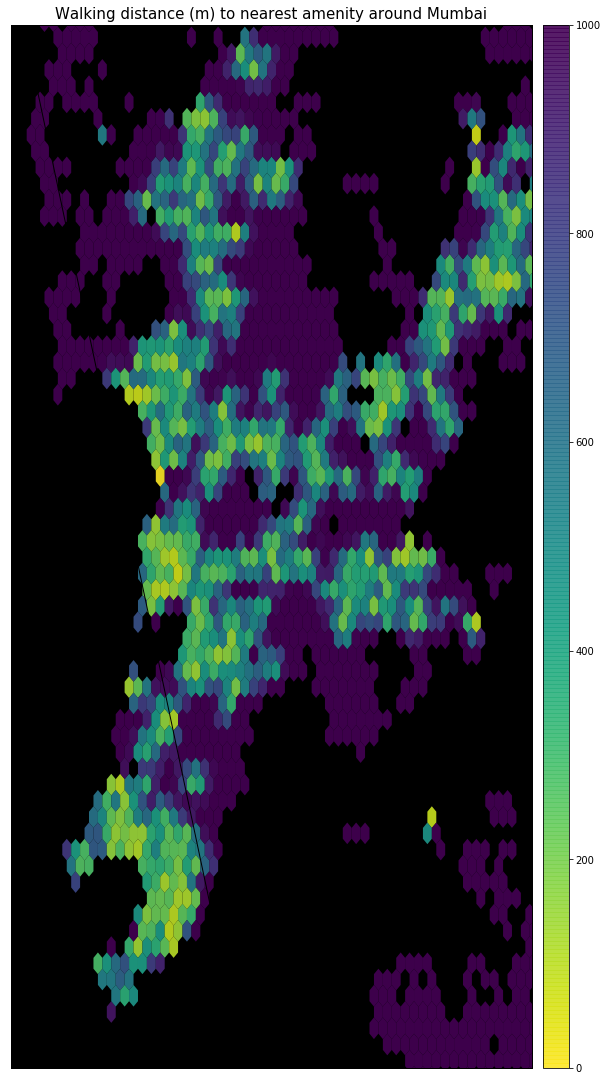

In [18]:
# distance to the nearest amenity of any type, as hexbins
bmap, fig, ax = network.plot(all_access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Mumbai', fontsize=15)
fig.savefig('images/accessibility-all-hexbin-Mumbai.png', dpi=200, bbox_inches='tight')

## 5. Calculate and plot accessibility separately for each amenity type

The amenity types specified at the beginning area: restaurants, bars, and schools

In [19]:
# initialize each amenity category with the locations specified by the lon and lat columns
for amenity in amenities:
    pois_subset = pois[pois['amenity']==amenity]
    network.set_pois(category=amenity, x_col=pois_subset['lon'], y_col=pois_subset['lat'])

Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()


/home/asus/anaconda3/lib/python3.7/site-packages/pandana/network.py:458: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  bbox[1], bbox[0], bbox[3], bbox[2], ax=ax, **bmap_kwargs)


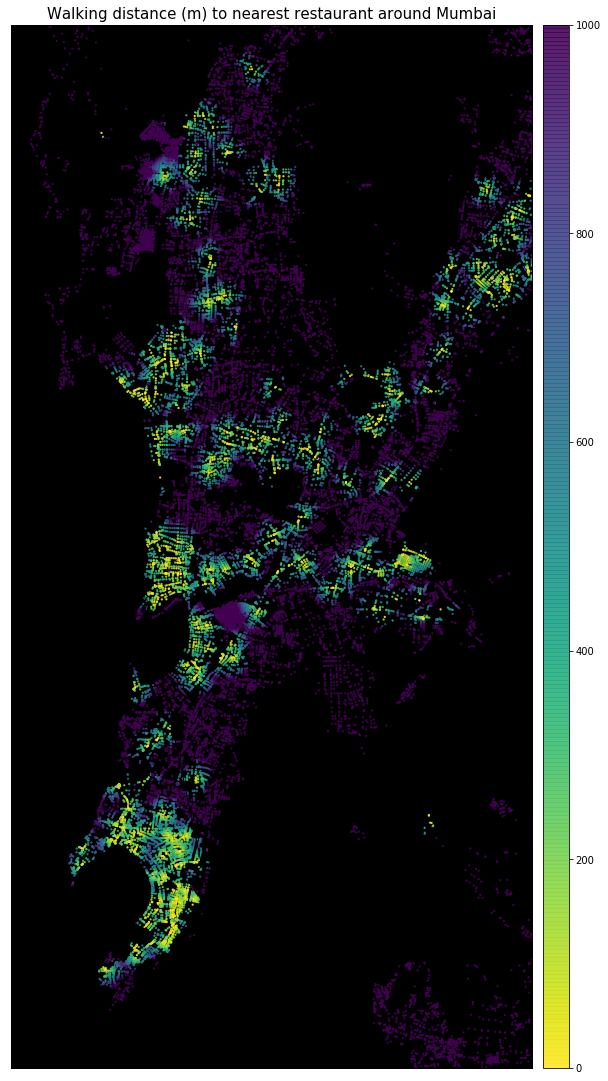

In [20]:
# distance to the nearest restaurant
restaurant_access = network.nearest_pois(distance=distance, category='restaurant', num_pois=num_pois)
bmap, fig, ax = network.plot(restaurant_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest restaurant around Mumbai', fontsize=15)
fig.savefig('images/accessibility-restaurant-Mumbai.png', dpi=200, bbox_inches='tight')

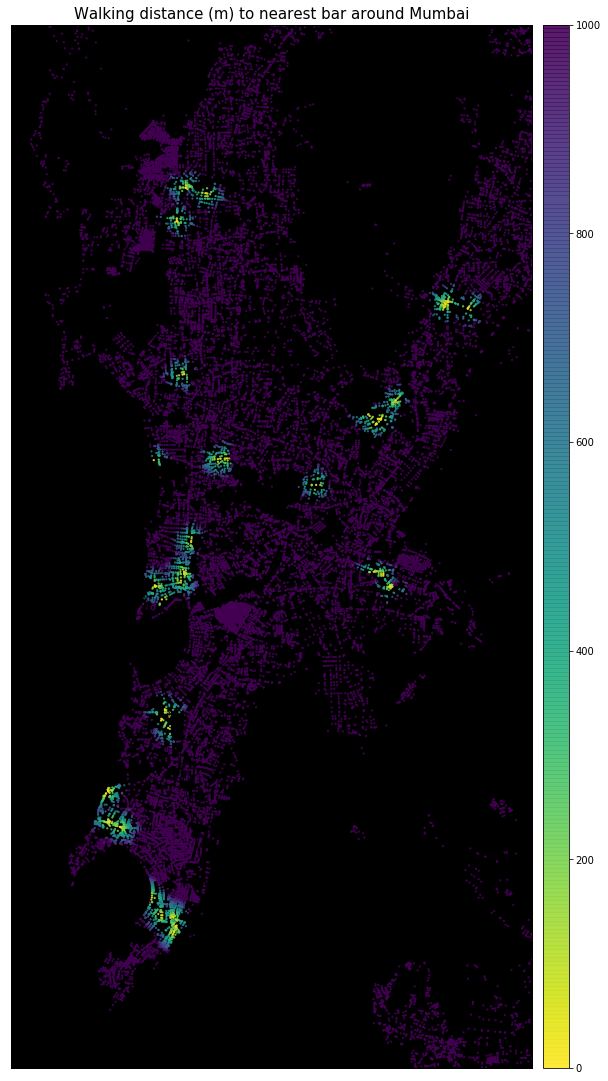

In [21]:
# distance to the nearest bar
bar_access = network.nearest_pois(distance=distance, category='bar', num_pois=num_pois)
bmap, fig, ax = network.plot(bar_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest bar around Mumbai', fontsize=15)
fig.savefig('images/accessibility-bar-Mumbai.png', dpi=200, bbox_inches='tight')

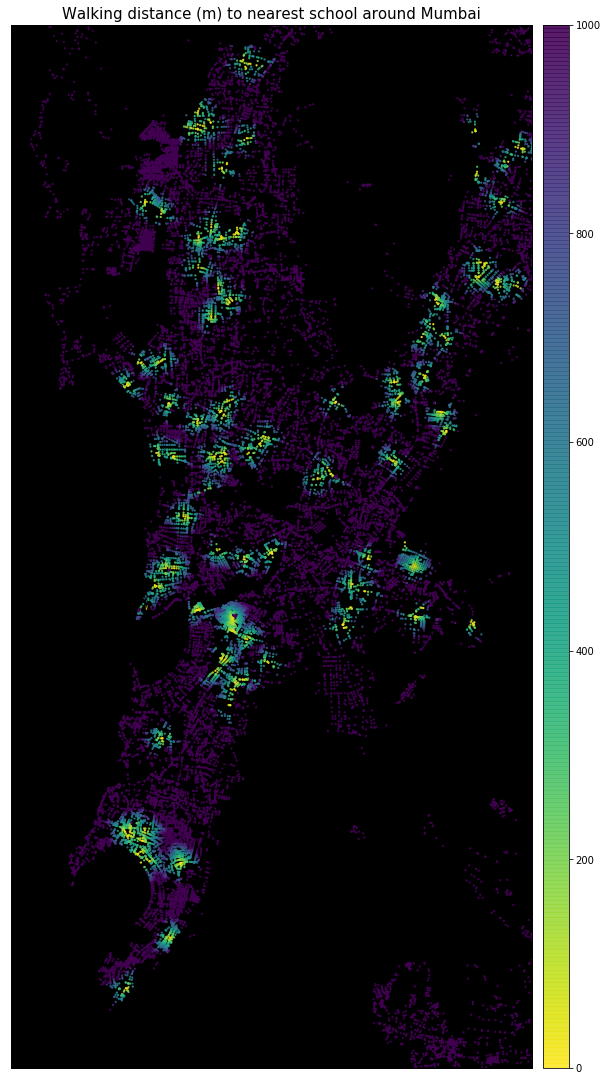

In [22]:
# distance to the nearest school
school_access = network.nearest_pois(distance=distance, category='school', num_pois=num_pois)
bmap, fig, ax = network.plot(school_access[1], bbox=bbox, plot_kwargs=plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest school around Mumbai', fontsize=15)
fig.savefig('images/accessibility-school-Mumbai.png', dpi=200, bbox_inches='tight')